In [198]:
import pandas_ta as ta
import pandas as pd
import yfinance as yf
import mplfinance as mpf

In [199]:
df = pd.DataFrame().ta.ticker("TSLA")

c:\Users\Arnas Vaicekauskas\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [200]:
short_window = 10
long_window = 20

df['sma-short'] = df['Close'].rolling(window=short_window).mean()
df['sma-long'] = df['Close'].rolling(window=long_window).mean()

df['signal'] = 0
df.loc[df['sma-short'] > df['sma-long'], 'signal'] = 1
df.loc[df['sma-short'] < df['sma-long'], 'signal'] = -1

df['dsignal'] = df['signal'].diff()

In [201]:
# take some interval
start_date, end_date = '2023-01-31', '2023-03-31'

df = df[df.index >= start_date]
df = df[df.index <= end_date]

In [202]:
offset = 10

# zero everywhere, except where buy action happened
df['buy_action'] = None
df.loc[df['dsignal'] > 0, 'buy_action'] = df['sma-short']

# zero everywhere, except where sell action happened
df['sell_action'] = None
df.loc[df['dsignal'] < 0, 'sell_action'] = df['sma-short']

In [203]:
take_profit = 300
stop_loss = 100

In [204]:
df['stop_loss'] = stop_loss
df['take_profit'] = take_profit

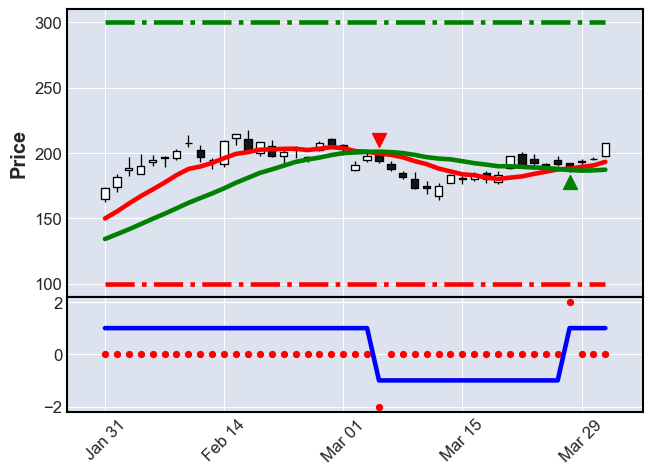

In [205]:
apds = [
    mpf.make_addplot(df['stop_loss'], color='r', linestyle='-.'),
    mpf.make_addplot(df['take_profit'], color='g', linestyle='-.'),
    mpf.make_addplot(df['buy_action'] - offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='^', color = 'green'),
    mpf.make_addplot(df['sell_action'] + offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='v', color = 'red'),
    mpf.make_addplot(df['dsignal'], type='scatter', panel=1, color='r', secondary_y=False),
    mpf.make_addplot(df['sma-short'], panel=0, color='r', secondary_y=False),
    mpf.make_addplot(df['sma-long'], panel=0, color='g', secondary_y=False),
    mpf.make_addplot(df['signal'], panel=1, color='b', secondary_y=False)
]

mpf.plot(df, type='candle', addplot=apds, volume=False)

In [207]:
def sell(date, balance, position, current_price, trade_fee, df):
    total = (1 - trade_fee) * position * current_price
    print(f'Sell {position:.2f} stock at {current_price:.2f} per stock (total: {total:.2f})')

    df.loc[date, 'dbalance'] = total

    balance += total

    df.loc[date, 'dposition'] = -position

    position = 0
    df.loc[date, 'dfee'] = trade_fee * position * current_price

    return (balance, position)
    

def buy(date, balance, position, current_price, trade_fee, df):
    amount = balance // ((1 + trade_fee) * current_price)
    total = (1 + trade_fee) * amount * current_price
    print(f'Buy {amount:.2f} stock at {current_price:.2f} per stock (total: {total:.2f})')
    position += amount
    balance -= total

    df.loc[date, 'dbalance'] = -total
    df.loc[date, 'dfee'] = trade_fee * amount * current_price
    df.loc[date, 'dposition'] = amount

    return (balance, position)
    

In [208]:
df['dbalance'] = 0.0
df['dfee'] = 0.0
df['dposition'] = 0.0

trade_fee = 0.02
starting_balance = 1000
balance = starting_balance # money units
position = 0 # stock units

for date, signal in zip(df.index, df['dsignal']):

    current_price = df['Close'][date]

    # calculate profit at time t
    if(current_price <= stop_loss or current_price >= take_profit):
 
        # sell & stop trading
        print('[stop loss]') if current_price <= stop_loss else print('[take profit]')
        balance, position = sell(date, balance, position, current_price, trade_fee, df)
        break

    if(signal == 0):
        continue

    print(f'[pos: {position}, bal: {balance}]')

    if(signal > 0): # buy
        balance, position = buy(date, balance, position, current_price, trade_fee, df)
    
    else: # sell
        balance, position = sell(date, balance, position, current_price, trade_fee, df)

# after simulation sell everything for last known price
print(f'[pos: {position}, bal: {balance}]')
balance, position = sell(date, balance, position, df['Close'][-1], trade_fee, df)
print(f'[pos: {position}, bal: {balance}]')

print(f'profit: {balance - starting_balance:.2f}')

print(f'min price: {df['Close'].min():.2f}')
print(f'max price: {df['Close'].max():.2f}')

[pos: 0, bal: 1000]
Sell 0.00 stock at 193.81 per stock (total: 0.00)
[pos: 0, bal: 1000.0]
Buy 5.00 stock at 189.19 per stock (total: 964.87)
[pos: 5.0, bal: 35.130987548828216]
Sell 5.00 stock at 207.46 per stock (total: 1016.55)
[pos: 0, bal: 1051.6850204467773]
profit: 51.69
min price: 172.92
max price: 214.24


C:\Users\Arnas Vaicekauskas\AppData\Local\Temp\ipykernel_24188\2482220946.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  balance, position = sell(date, balance, position, df['Close'][-1], trade_fee, df)


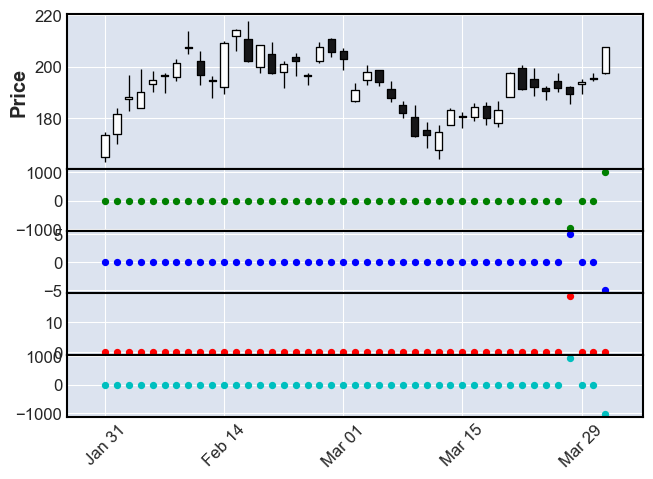

In [220]:
# portfolio worth at time t?
df['dprofit'] = 0
df['dprofit'] = df['dposition'] * df['Close'] - df['dbalance']


apds = [
    mpf.make_addplot(df['dfee'], type='scatter', panel=3, color='r'),
    mpf.make_addplot(df['dbalance'], type='scatter', panel=1, color='g'),
    mpf.make_addplot(df['dposition'], type='scatter', panel=2, color='b'),
    mpf.make_addplot(df['dprofit'], type='scatter', panel=4, color='c'),
]

mpf.plot(df, type='candle', addplot=apds, volume=False)

In [210]:
df['dposition']

Date
2023-01-31 00:00:00-05:00    0.0
2023-02-01 00:00:00-05:00    0.0
2023-02-02 00:00:00-05:00    0.0
2023-02-03 00:00:00-05:00    0.0
2023-02-06 00:00:00-05:00    0.0
2023-02-07 00:00:00-05:00    0.0
2023-02-08 00:00:00-05:00    0.0
2023-02-09 00:00:00-05:00    0.0
2023-02-10 00:00:00-05:00    0.0
2023-02-13 00:00:00-05:00    0.0
2023-02-14 00:00:00-05:00    0.0
2023-02-15 00:00:00-05:00    0.0
2023-02-16 00:00:00-05:00    0.0
2023-02-17 00:00:00-05:00    0.0
2023-02-21 00:00:00-05:00    0.0
2023-02-22 00:00:00-05:00    0.0
2023-02-23 00:00:00-05:00    0.0
2023-02-24 00:00:00-05:00    0.0
2023-02-27 00:00:00-05:00    0.0
2023-02-28 00:00:00-05:00    0.0
2023-03-01 00:00:00-05:00    0.0
2023-03-02 00:00:00-05:00    0.0
2023-03-03 00:00:00-05:00    0.0
2023-03-06 00:00:00-05:00    0.0
2023-03-07 00:00:00-05:00    0.0
2023-03-08 00:00:00-05:00    0.0
2023-03-09 00:00:00-05:00    0.0
2023-03-10 00:00:00-05:00    0.0
2023-03-13 00:00:00-04:00    0.0
2023-03-14 00:00:00-04:00    0.0
2023-

In [211]:
df.index

DatetimeIndex(['2023-01-31 00:00:00-05:00', '2023-02-01 00:00:00-05:00',
               '2023-02-02 00:00:00-05:00', '2023-02-03 00:00:00-05:00',
               '2023-02-06 00:00:00-05:00', '2023-02-07 00:00:00-05:00',
               '2023-02-08 00:00:00-05:00', '2023-02-09 00:00:00-05:00',
               '2023-02-10 00:00:00-05:00', '2023-02-13 00:00:00-05:00',
               '2023-02-14 00:00:00-05:00', '2023-02-15 00:00:00-05:00',
               '2023-02-16 00:00:00-05:00', '2023-02-17 00:00:00-05:00',
               '2023-02-21 00:00:00-05:00', '2023-02-22 00:00:00-05:00',
               '2023-02-23 00:00:00-05:00', '2023-02-24 00:00:00-05:00',
               '2023-02-27 00:00:00-05:00', '2023-02-28 00:00:00-05:00',
               '2023-03-01 00:00:00-05:00', '2023-03-02 00:00:00-05:00',
               '2023-03-03 00:00:00-05:00', '2023-03-06 00:00:00-05:00',
               '2023-03-07 00:00:00-05:00', '2023-03-08 00:00:00-05:00',
               '2023-03-09 00:00:00-05:00', '2023-0